<a href="https://colab.research.google.com/github/jai2shan/TSAI-EVA40-Assignments/blob/master/Session%2010/Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# !git clone https://github.com/jai2shan/TSAI-EVA40-Assignments.git
import os
os.chdir(r'/content/TSAI-EVA40-Assignments/Session 10/asgnmt10')

In [9]:
from torchvision import transforms
from DataLoader import cifar_data_loader,View_images
from cutout import *
import torch
from torchsummary import summary
from resnet import ResNet18

from LR_Finder import *
from Training_Testing import TrainTest
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from ModelPerformance import *
from gradcam import GradCamDisplay
import PIL
from gradcam import *
import copy
import pandas as pd

In [7]:
trainloader,testloader = cifar_data_loader(BatchSize=250)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

net = ResNet18().to(device)
summary(net, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,


Learning rate search finished. See the graph with {finder_name}.plot()


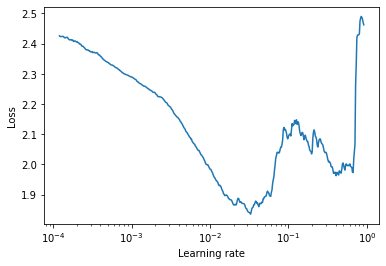

ValueError: ignored

In [10]:
tt = TrainTest()
test_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001)
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

lr_finder = LRFinder(net, optimizer, criterion)
lr_finder.range_test(trainloader, end_lr=1, num_iter=500,step_mode="exp")
lr_finder.plot()

lr_ = pd.DataFrame(lr_finder)

In [24]:
lr_ = pd.DataFrame(lr_finder.history)
lr_max = lr_.loc[lr_['loss']==lr_['loss'].min(),'lr'].values[0]

In [25]:
tt = TrainTest()
test_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr_max, momentum=0.9,weight_decay = 0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

for epoch in range(50):
    print("EPOCH:", epoch)
    tt.train_(net, device, trainloader, optimizer, criterion, epoch,L1 = False)
    acc = tt.test_(net, device, testloader)  
    scheduler.step(tt.test_losses[epoch])
       
print('Finished Training')

  0%|          | 0/200 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.687981128692627 Batch_id=199 Accuracy=33.63: 100%|██████████| 200/200 [00:37<00:00,  5.35it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -2.8448, Accuracy: 4226/10000 (42.26%)

EPOCH: 1


Loss=1.48589289188385 Batch_id=199 Accuracy=45.61: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -3.1248, Accuracy: 5069/10000 (50.69%)

EPOCH: 2


Loss=1.2435739040374756 Batch_id=199 Accuracy=51.90: 100%|██████████| 200/200 [00:37<00:00,  5.35it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -3.8476, Accuracy: 5672/10000 (56.72%)

EPOCH: 3


Loss=1.0200419425964355 Batch_id=199 Accuracy=57.58: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -4.1935, Accuracy: 6392/10000 (63.92%)

EPOCH: 4


Loss=1.1011253595352173 Batch_id=199 Accuracy=61.54: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -4.8484, Accuracy: 6439/10000 (64.39%)

EPOCH: 5


Loss=1.0488612651824951 Batch_id=199 Accuracy=64.65: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -5.6207, Accuracy: 6882/10000 (68.82%)

EPOCH: 6


Loss=0.9726967811584473 Batch_id=199 Accuracy=66.77: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -5.9880, Accuracy: 7372/10000 (73.72%)

EPOCH: 7


Loss=0.8302767872810364 Batch_id=199 Accuracy=69.45: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -5.9568, Accuracy: 7360/10000 (73.60%)

EPOCH: 8


Loss=0.8577093482017517 Batch_id=199 Accuracy=71.44: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -6.5480, Accuracy: 7719/10000 (77.19%)

EPOCH: 9


Loss=0.7685806751251221 Batch_id=199 Accuracy=72.94: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -6.8327, Accuracy: 7866/10000 (78.66%)

EPOCH: 10


Loss=0.6895933151245117 Batch_id=199 Accuracy=74.46: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.1748, Accuracy: 8040/10000 (80.40%)

EPOCH: 11


Loss=0.7902685403823853 Batch_id=199 Accuracy=75.91: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.4651, Accuracy: 8076/10000 (80.76%)

EPOCH: 12


Loss=0.8577632904052734 Batch_id=199 Accuracy=76.77: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.8134, Accuracy: 8207/10000 (82.07%)

EPOCH: 13


Loss=0.5891313552856445 Batch_id=199 Accuracy=77.96: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.8555, Accuracy: 8009/10000 (80.09%)

EPOCH: 14


Loss=0.5694798827171326 Batch_id=199 Accuracy=78.69: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.3468, Accuracy: 8310/10000 (83.10%)

EPOCH: 15


Loss=0.632079005241394 Batch_id=199 Accuracy=79.42: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.1942, Accuracy: 8375/10000 (83.75%)

EPOCH: 16


Loss=0.5620555281639099 Batch_id=199 Accuracy=80.25: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.2697, Accuracy: 8460/10000 (84.60%)

EPOCH: 17


Loss=0.5843019485473633 Batch_id=199 Accuracy=80.35: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.4307, Accuracy: 8043/10000 (80.43%)

EPOCH: 18


Loss=0.5751076340675354 Batch_id=199 Accuracy=81.21: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.1479, Accuracy: 8431/10000 (84.31%)

EPOCH: 19


Loss=0.5021848082542419 Batch_id=199 Accuracy=81.95: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.4301, Accuracy: 8610/10000 (86.10%)

EPOCH: 20


Loss=0.6336774230003357 Batch_id=199 Accuracy=82.26: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.0908, Accuracy: 8619/10000 (86.19%)

EPOCH: 21


Loss=0.4592582881450653 Batch_id=199 Accuracy=82.39: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.5894, Accuracy: 8592/10000 (85.92%)

EPOCH: 22


Loss=0.4677674174308777 Batch_id=199 Accuracy=83.03: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.7817, Accuracy: 8609/10000 (86.09%)

EPOCH: 23


Loss=0.5231428742408752 Batch_id=199 Accuracy=83.36: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.0066, Accuracy: 8538/10000 (85.38%)

EPOCH: 24


Loss=0.3243147134780884 Batch_id=199 Accuracy=83.74: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.3065, Accuracy: 8654/10000 (86.54%)

EPOCH: 25


Loss=0.41105374693870544 Batch_id=199 Accuracy=84.07: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.3976, Accuracy: 8685/10000 (86.85%)

EPOCH: 26


Loss=0.41952961683273315 Batch_id=199 Accuracy=84.34: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.1069, Accuracy: 8683/10000 (86.83%)

EPOCH: 27


Loss=0.3136463761329651 Batch_id=199 Accuracy=84.77: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.4556, Accuracy: 8767/10000 (87.67%)

EPOCH: 28


Loss=0.40991225838661194 Batch_id=199 Accuracy=84.91: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.0094, Accuracy: 8734/10000 (87.34%)

EPOCH: 29


Loss=0.5163794159889221 Batch_id=199 Accuracy=85.21: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.3924, Accuracy: 8776/10000 (87.76%)

EPOCH: 30


Loss=0.4862343668937683 Batch_id=199 Accuracy=85.47: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.1494, Accuracy: 8767/10000 (87.67%)

EPOCH: 31


Loss=0.4110860526561737 Batch_id=199 Accuracy=85.86: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.3787, Accuracy: 8868/10000 (88.68%)

EPOCH: 32


Loss=0.31453821063041687 Batch_id=199 Accuracy=86.10: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.4592, Accuracy: 8924/10000 (89.24%)

EPOCH: 33


Loss=0.3730889558792114 Batch_id=199 Accuracy=86.05: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.2599, Accuracy: 8858/10000 (88.58%)

EPOCH: 34


Loss=0.3751702904701233 Batch_id=199 Accuracy=86.68: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.5546, Accuracy: 8813/10000 (88.13%)

EPOCH: 35


Loss=0.413512259721756 Batch_id=199 Accuracy=86.59: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.5910, Accuracy: 8957/10000 (89.57%)

EPOCH: 36


Loss=0.4257182776927948 Batch_id=199 Accuracy=87.07: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.3355, Accuracy: 8833/10000 (88.33%)

EPOCH: 37


Loss=0.39722466468811035 Batch_id=199 Accuracy=86.92: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.5398, Accuracy: 8965/10000 (89.65%)

EPOCH: 38


Loss=0.4015568494796753 Batch_id=199 Accuracy=87.35: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.2594, Accuracy: 8917/10000 (89.17%)

EPOCH: 39


Loss=0.33661943674087524 Batch_id=199 Accuracy=87.43: 100%|██████████| 200/200 [00:36<00:00,  5.46it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.5898, Accuracy: 8892/10000 (88.92%)

EPOCH: 40


Loss=0.412595272064209 Batch_id=199 Accuracy=87.47: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.4106, Accuracy: 8948/10000 (89.48%)

EPOCH: 41


Loss=0.33748191595077515 Batch_id=199 Accuracy=87.85: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.5859, Accuracy: 8857/10000 (88.57%)

EPOCH: 42


Loss=0.3744847774505615 Batch_id=199 Accuracy=87.80: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.2312, Accuracy: 8842/10000 (88.42%)

EPOCH: 43


Loss=0.41568052768707275 Batch_id=199 Accuracy=87.96: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.5333, Accuracy: 8926/10000 (89.26%)

EPOCH: 44


Loss=0.3165973424911499 Batch_id=199 Accuracy=88.05: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.4948, Accuracy: 8769/10000 (87.69%)

EPOCH: 45


Loss=0.3305175006389618 Batch_id=199 Accuracy=88.34: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.8519, Accuracy: 9043/10000 (90.43%)

EPOCH: 46


Loss=0.3453912138938904 Batch_id=199 Accuracy=88.13: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.3689, Accuracy: 8875/10000 (88.75%)

EPOCH: 47


Loss=0.33631643652915955 Batch_id=199 Accuracy=88.46: 100%|██████████| 200/200 [00:36<00:00,  5.45it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.7627, Accuracy: 9017/10000 (90.17%)

EPOCH: 48


Loss=0.2910306453704834 Batch_id=199 Accuracy=88.49: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.4892, Accuracy: 8968/10000 (89.68%)

EPOCH: 49


Loss=0.29482579231262207 Batch_id=199 Accuracy=88.40: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]



Test set: Average loss: -9.4315, Accuracy: 8992/10000 (89.92%)

Finished Training


In [ ]:
PlotTrainingGraphs(tt)

In [ ]:
Misclassification(testloader,net,classes,device)

In [ ]:
from gradcam import GradCamDisplay
import PIL
img_name =['airplane.png','automobile.png','bird.png','cat.png','deer.png']

pil_image = []
for i,img in enumerate(img_name):
   pil_image.append(PIL.Image.open(img))

In [ ]:
from pylab import *
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4],padding=1))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
images[:4]